In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
import os
import detection as dt

Set-Up

In [2]:
tickers = ["AMSC", "BP", "EVR", "GOOGL", "HLF", "MDRX", "ORCL", "WFC"]
auto_threshold = True
threshold = 2.1
pattern_lengths=[10, 15, 20, 25, 30, 35, 40, 45, 50]
window_size=50
overlap=10
percentile=10
data_dir = '../trades/data/output'
output_dir = 'detection/data/output'

Loading data...

In [3]:
# Generate patterns once (they're the same for all tickers)
patterns = dt.generate_insider_patterns(pattern_lengths)
print(f"Generated {len(patterns)} insider trading patterns\n")

data_dicts_enhanced = {}
data_dicts = {}

for ticker in tickers:
    print(f"Processing ticker: {ticker}")
    
    # Load enhanced data
    data_dict_enhanced = dt.load_ticker_data(ticker, 'enhanced', data_dir)
    
    # Load baseline data
    data_dict = dt.load_ticker_data(ticker, 'baseline', data_dir)
    
    # Store in dictionaries
    data_dicts_enhanced[ticker] = data_dict_enhanced
    data_dicts[ticker] = data_dict

Generated 9 insider trading patterns

Processing ticker: AMSC
Processing ticker: BP
Processing ticker: EVR
Processing ticker: GOOGL
Processing ticker: HLF
Processing ticker: MDRX
Processing ticker: ORCL
Processing ticker: WFC


Determining threshold...

In [4]:
if auto_threshold:
        distances = dt.sample_dtw_distances(data_dict['point'], patterns, 
                                        window_size, overlap, sample_rate=0.2)
        threshold = dt.suggest_threshold(distances, percentile)
        # Distance distribution for baseline metho
        distances_enhanced = dt.sample_dtw_distances(data_dict_enhanced['point'], patterns, 
                                        window_size, overlap, sample_rate=0.2)
        threshold_enhanced = dt.suggest_threshold(distances_enhanced, percentile)
else:
    print(f"3. Using manual threshold: {threshold}\n")


DTW Distance Distribution:
  min     :  2.440
  p10     :  6.730
  p25     : 10.076
  median  : 13.503
  p75     : 18.718
  max     : 57.220

Suggested threshold (10th %ile): 6.730

DTW Distance Distribution:
  min     :  2.554
  p10     :  7.666
  p25     : 10.030
  median  : 14.166
  p75     : 20.712
  max     : 54.139

Suggested threshold (10th %ile): 7.666


Detection   

In [5]:
# Initialize result storage
all_results = {}
all_results_enhanced = {}

for ticker in tickers:
    # Get data for this specific ticker
    data_dict = data_dicts[ticker]
    data_dict_enhanced = data_dicts_enhanced[ticker]
    
    # Run detection for baseline method
    results = dt.run_detection(data_dict, patterns, threshold, window_size, overlap)
    
    # Run detection for enhanced method
    results_enhanced = dt.run_detection(data_dict_enhanced, patterns, threshold_enhanced, window_size, overlap)
    
    # Store results for this ticker
    all_results[ticker] = results
    all_results_enhanced[ticker] = results_enhanced


Point-by-Point      :  142 anomalies
Sequence            :  785 anomalies
Window              :  785 anomalies
Point-by-Point      :  223 anomalies
Sequence            : 1026 anomalies
Window              : 1026 anomalies
Point-by-Point      :  145 anomalies
Sequence            : 1327 anomalies
Window              : 1327 anomalies
Point-by-Point      :  239 anomalies
Sequence            :   23 anomalies
Window              :   23 anomalies
Point-by-Point      :  162 anomalies
Sequence            : 1378 anomalies
Window              : 1378 anomalies
Point-by-Point      :  253 anomalies
Sequence            : 1578 anomalies
Window              : 1578 anomalies
Point-by-Point      :  129 anomalies
Sequence            : 1415 anomalies
Window              : 1415 anomalies
Point-by-Point      :  202 anomalies
Sequence            : 1587 anomalies
Window              : 1587 anomalies
Point-by-Point      :  142 anomalies
Sequence            :  939 anomalies
Window              :  939 anomalies
P

Summary

In [6]:

# Summarize results across all tickers
print("\n=== BASELINE METHOD ===")
total = sum(len(v) for ticker_results in all_results.values() for v in ticker_results.values())
print(f"Total anomalies detected: {total}\n")

for ticker in tickers:
    summary = dt.summarize_results(all_results[ticker])
    if not summary.empty:
        print(f"\n{ticker}:")
        print(summary.to_string(index=False))

print("\n\nPattern Breakdown:")
for ticker in tickers:
    breakdown = dt.pattern_breakdown(all_results[ticker])
    if not breakdown.empty:
        print(f"\n{ticker}:")
        print(breakdown.to_string())

print("\n\n=== ENHANCED METHOD ===")
total_enhanced = sum(len(v) for ticker_results in all_results_enhanced.values() for v in ticker_results.values())
print(f"Total anomalies detected: {total_enhanced}\n")

for ticker in tickers:
    summary_enhanced = dt.summarize_results(all_results_enhanced[ticker])
    if not summary_enhanced.empty:
        print(f"\n{ticker}:")
        print(summary_enhanced.to_string(index=False))

print("\n\nPattern Breakdown:")
for ticker in tickers:
    breakdown_enhanced = dt.pattern_breakdown(all_results_enhanced[ticker])
    if not breakdown_enhanced.empty:
        print(f"\n{ticker}:")
        print(breakdown_enhanced.to_string())

if total == 0 and total_enhanced == 0:
    print("\nNo anomalies detected across any tickers")


=== BASELINE METHOD ===
Total anomalies detected: 16533


AMSC:
        Method  Count  DTW Min  DTW Mean  DTW Max  Patterns
Point-by-Point    142 2.855196  5.448840 6.721863         3
      Sequence    785 3.146455  4.899637 6.721907         5
        Window    785 3.146455  4.899637 6.721907         5

BP:
        Method  Count  DTW Min  DTW Mean  DTW Max  Patterns
Point-by-Point    145 1.497440  5.427816 6.720488         3
      Sequence   1327 2.774899  4.776932 6.722642         4
        Window   1327 2.774899  4.776932 6.722642         4

EVR:
        Method  Count  DTW Min  DTW Mean  DTW Max  Patterns
Point-by-Point    162 2.388931  5.392177 6.693587         3
      Sequence   1378 3.267025  4.780911 6.718185         4
        Window   1378 3.267025  4.780911 6.718185         4

GOOGL:
        Method  Count  DTW Min  DTW Mean  DTW Max  Patterns
Point-by-Point    129 1.655896  5.190199 6.724419         3
      Sequence   1415 3.129781  4.781982 6.704910         4
        Window  

# Visualizing   

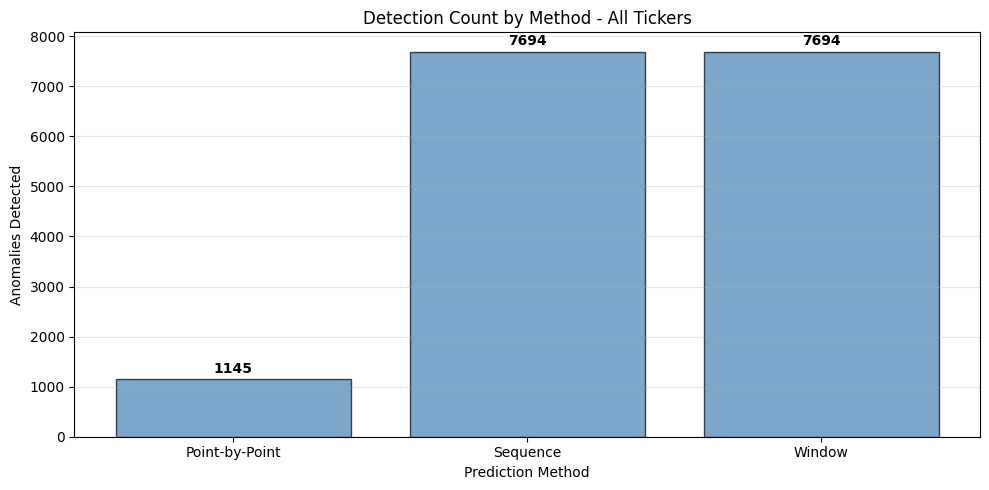

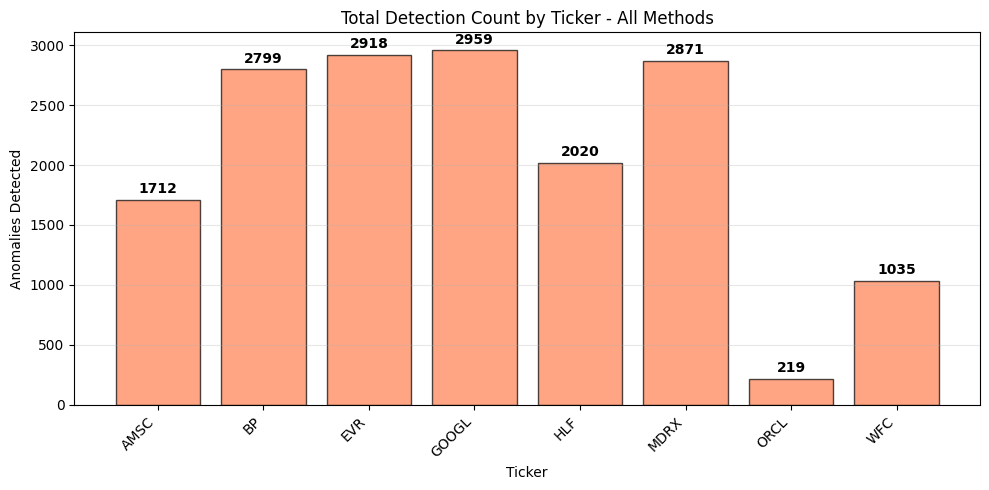

In [7]:

# Compare methods for a specific ticker
#dt.plot_method_comparison(all_results, ticker='AMSC')

# Compare methods across all tickers (aggregated)
dt.plot_method_comparison(all_results)


# NEW: Compare total detections across tickers
dt.plot_ticker_comparison(all_results)


In [10]:
# For baseline results
dt.plot_top_anomalies(all_results, ticker='BP', method_name='window_based', 
                     top_n=5, window_size=window_size)

# For enhanced results
dt.plot_top_anomalies(all_results_enhanced, ticker='BP', method_name='window_based', 
                     top_n=3, window_size=window_size)

No anomalies for BP - window_based
No anomalies for BP - window_based
